In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Define Analysis Functions

In [2]:
def get_variable(domain='atm',var='TREFHT',h='h0',runname='COUP0000_1850spinup_SOM_v02'):
    if var=='RESTOM':
        fsnt = get_variable(domain='atm',var='FSNT',h=h,runname=runname)
        flnt = get_variable(domain='atm',var='FLNT',h=h,runname=runname)
        ds=fsnt
        ds['RESTOM'] = fsnt.FSNT-flnt.FLNT
    else:
        fpath = '/glade/scratch/czarakas/archive/'+runname+'/'+domain+'/proc/tseries/'
        fname = fpath+'*'+h+'*.'+var+'.nc'
        #print(fname)
        ds = xr.open_mfdataset(fname, combine='by_coords')
    return ds

In [3]:
def global_avg_atm(ds, var):
    coslat = np.cos(np.deg2rad(ds.lat))
    atm_weights = coslat / coslat.mean(dim='lat') 
    
    return (ds[var]*atm_weights).mean(dim=['lat','lon'])

In [4]:
ds1=xr.open_dataset('/glade/scratch/czarakas/archive/COUP0000_1850spinup_SOM_v02/atm/hist/COUP0000_1850spinup_SOM_v02.cam.h0.0001-01.nc')
ds2=xr.open_dataset('/glade/scratch/czarakas/archive/COUP0000_1850spinup_SOM_v02/lnd/hist/COUP0000_1850spinup_SOM_v02.clm2.h0.0001-02-01-00000.nc')

In [5]:
def global_avg_lnd(ds, var):
    land_area=ds2.area*ds2.landfrac
    land_weights = land_area/land_area.sum(dim=['lat','lon'])
    return ((ds[var])*(land_weights)).sum(dim=['lat','lon'])

In [6]:
def calculate_annual_trend(var='TREFHT', domain='atm', 
                           runname='coupled_DEFmedslope_1xCO2_02', numyears=20):
    ds = get_variable(domain=domain,var=var,runname=runname)
    ds_annual = ds.groupby('time.year').mean(dim='time')
    if domain=='atm':
        tseries_global_annual = global_avg_atm(ds_annual, var)
    else:
        tseries_global_annual = global_avg_lnd(ds_annual, var)
        
    var_annual = tseries_global_annual[1:-1]
    years = ds_annual.year[1:-1]
    
    var_annual_end = var_annual[(np.size(var_annual.year)-numyears):np.size(var_annual.year)]
    years_end = years[(np.size(var_annual.year)-numyears):np.size(var_annual.year)]
    [slope, intercept, r_value, p_value, std_err] = stats.linregress(years_end,var_annual_end)
    
    return [slope, p_value, var_annual, years, years_end]

# Plot Time Series of Key Variables

In [7]:
# something is off with TSA and with FSNO

vars_to_plot = ['TREFHT','TS','TBOT','TSKIN','TSA',
                'FLNT','FSNT','RESTOM','TWS','ICEFRAC', 'FSNO',
                'TSAI','TLAI','GPP','ER','AR',
                'NPP','NEE','HTOP',
                'TOTVEGC','TOTVEGN','TOTECOSYSC','TOTECOSYSN']

domains=['atm','atm','lnd','lnd', 'lnd',
         'atm','atm','atm','lnd', 'atm', 'lnd',
         'lnd','lnd','lnd','lnd','lnd',
         'lnd','lnd','lnd',
         'lnd','lnd','lnd','lnd']

TREFHT
TS
TBOT
TSKIN
TSA
FLNT
FSNT
RESTOM
TWS
ICEFRAC
FSNO
TSAI
TLAI
GPP
ER
AR
NPP
NEE
HTOP
TOTVEGC
TOTVEGN
TOTECOSYSC
TOTECOSYSN


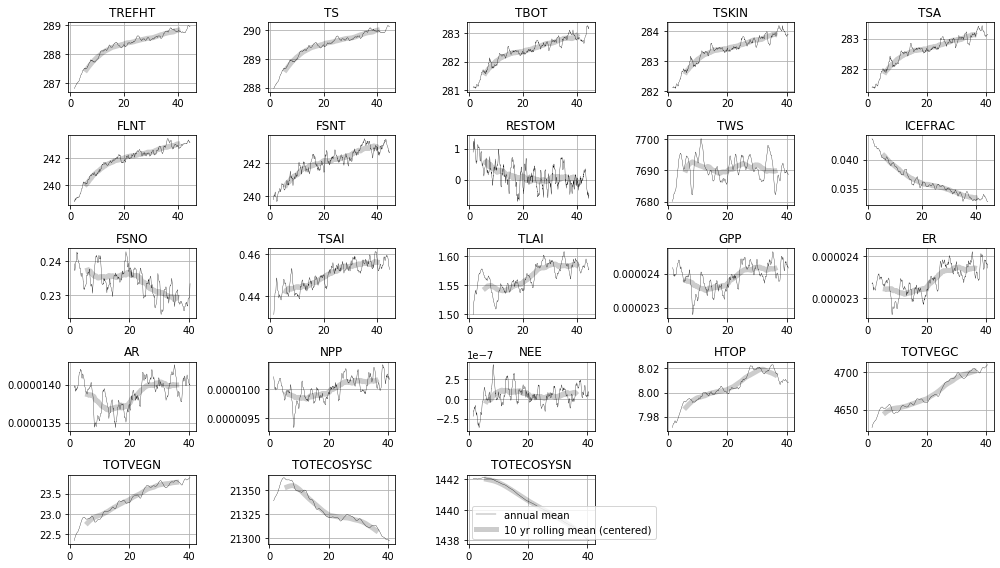

In [8]:
plt.figure(figsize=(14,8))
dt=10
for i, var in enumerate(vars_to_plot):
    print(var)
    domain = domains[i]
    var_1xCO2 = get_variable(domain=domain,var=var,runname='COUP0000_1850spinup_SOM_v02').load()
    if domain=='atm':
        var_1xCO2_global = global_avg_atm(var_1xCO2, var)
    elif domain=='lnd':
        var_1xCO2_global = global_avg_lnd(var_1xCO2, var)
    
    plt.subplot(5,5,i+1)
    plt.plot(np.arange(0, np.size(var_1xCO2_global.time))/12+1,
             var_1xCO2_global.rolling(time=12, center=True).mean(),
             '-k',linewidth=0.3,label='annual mean')
    plt.plot(np.arange(0, np.size(var_1xCO2_global.time))/12+1,
             var_1xCO2_global.rolling(time=12*dt, center=True).mean(),
             '-k',linewidth=5, alpha=0.2,label=str(dt)+' yr rolling mean (centered)')
    plt.title(var)
    plt.grid()
    
plt.legend()
plt.tight_layout()

# Look at single variable

TREFHT-----------
0.02037663565587749
1.5037529901235457e-06


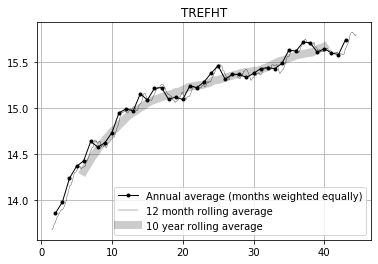

In [9]:
var='TREFHT'
domain='atm'
runname='COUP0000_1850spinup_SOM_v02'
numyears=20

var_ds = get_variable(domain=domain,var=var,runname=runname)
if domain=='atm':
    var_global = global_avg_atm(var_ds, var)-273.15
elif domain=='lnd':
    var_global = global_avg_lnd(var_ds, var)-273.15
var_global_annual = var_global.groupby('time.year').mean(dim='time')[1:-1]
    
plt.plot(np.arange(0, np.size(var_global_annual.year))+2,
             var_global_annual,
             '.-k',linewidth=1, label='Annual average (months weighted equally)')
plt.plot(np.arange(0, np.size(var_global.time))/12+1,
             var_global.rolling(time=12, center=True).mean(),
             '-k',linewidth=0.3, label='12 month rolling average')
plt.plot(np.arange(0, np.size(var_global.time))/12+1,
             var_global.rolling(time=12*10, center=True).mean(),
             '-k',linewidth=8, alpha=0.2,label='10 year rolling average')
plt.title(var)
plt.grid()
plt.legend()

[slope, p_value, _, _, _] = calculate_annual_trend(var=var, domain=domain, 
                                                   runname=runname, numyears=20)
print(var+'-----------')
print(slope)
print(p_value)

# Analyze which variables have statistically significant trends at end of time series

In [10]:
vars_with_trends = []
vars_without_trends = []
for i, var in enumerate(vars_to_plot):
    domain = domains[i]
    [slope, p_value, _, _, _] = calculate_annual_trend(var=var, domain=domain, 
                                                       runname='COUP0000_1850spinup_SOM_v02', 
                                                       numyears=20)
    print(var+'-----------')
    print(slope)
    if p_value<0.05:
        print('**'+str(p_value))
        vars_with_trends.append(var)
    else:  
        print(p_value)
        vars_without_trends.append(var)

TREFHT-----------
0.02037663565587749
**1.5037529901235457e-06
TS-----------
0.020869713871720656
**1.0567063314771158e-06


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TBOT-----------
0.019490223361137222
**0.001285804286145148


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TSKIN-----------
0.03285951542675047
**4.469514154297142e-07


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TSA-----------
0.032038638466282895
**7.204669082160301e-07
FLNT-----------
0.046924451886112654
**2.8596765682307395e-05
FSNT-----------
0.046784054773359826
**0.0012589082801616892
RESTOM-----------
-0.00014040493110885973
0.9917019236569045


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TWS-----------
-0.18465328359962407
0.14449795363487547
ICEFRAC-----------
-0.00014164175870683135
**6.247348038913682e-08


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


FSNO-----------
-0.0004933265366948638
**3.074335044035775e-06


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TSAI-----------
0.00021690831596690014
**0.030219244204582496


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TLAI-----------
-1.3885910349680967e-05
0.973216921336761


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GPP-----------
1.5383185179820078e-08
0.1579660912473807


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ER-----------
1.7144721871437997e-08
0.05916187267856131


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


AR-----------
7.4977006284429e-09
0.19772205969173104


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


NPP-----------
7.885538573994799e-09
0.17003540328258482


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


NEE-----------
5.4921668482929175e-09
0.11977717557784658


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


HTOP-----------
0.0005880843427844514
**0.028744476332156575


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TOTVEGC-----------
2.2268242628054513
**5.824637137561982e-10


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TOTVEGN-----------
0.022871308577688116
**5.433833169299476e-07


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TOTECOSYSC-----------
-1.0949160009398498
**5.606049082903043e-07
TOTECOSYSN-----------
-0.11990975975093984
**9.884089473551286e-21


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [11]:
vars_with_trends

['TREFHT',
 'TS',
 'TBOT',
 'TSKIN',
 'TSA',
 'FLNT',
 'FSNT',
 'ICEFRAC',
 'FSNO',
 'TSAI',
 'HTOP',
 'TOTVEGC',
 'TOTVEGN',
 'TOTECOSYSC',
 'TOTECOSYSN']

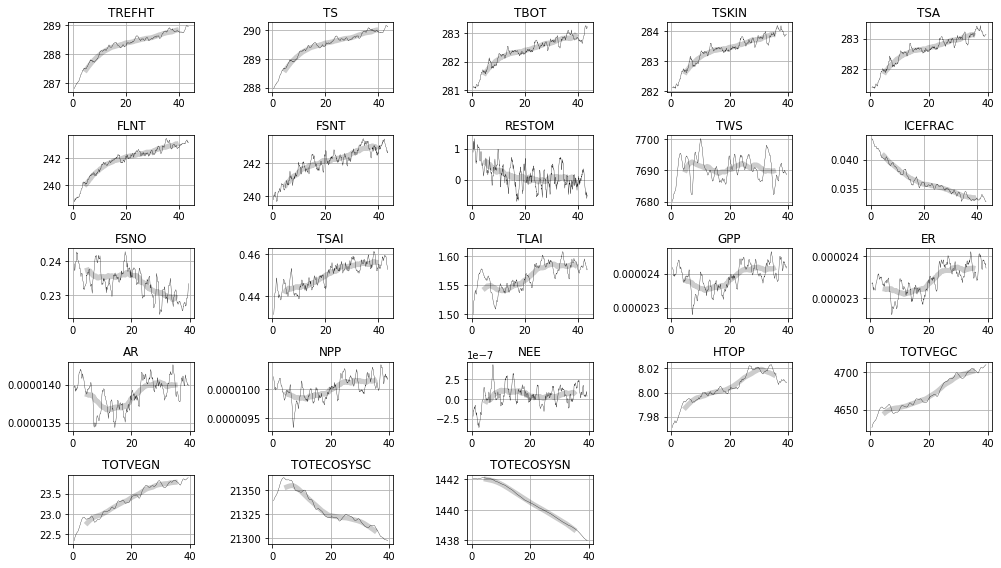

In [13]:
plt.figure(figsize=(14,8))
for i, var in enumerate(vars_to_plot):
    domain = domains[i]
    var_1run = get_variable(domain=domain,var=var,runname='COUP0000_1850spinup_SOM_v02')
    if domain=='atm':
        var_1run_global = global_avg_atm(var_1run, var)
    elif domain=='lnd':
        var_1run_global = global_avg_lnd(var_1run, var)
    
    plt.subplot(5,5,i+1)
    plt.plot(np.arange(0, np.size(var_1run_global.time))/12,
             var_1run_global.rolling(time=12, center=True).mean(),
             '-k',linewidth=0.3,label='12 month rolling mean')
    plt.plot(np.arange(0, np.size(var_1run_global.time))/12,
             var_1run_global.rolling(time=12*10, center=True).mean(),
             '-k',linewidth=5, alpha=0.2,label='10 year rolling mean')
    plt.title(var)
    plt.grid()
    
plt.tight_layout()